In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline



In [2]:
# путь к data
DATA_PATH = "../../data/task_2/"
# Глобальное значение "random_state" 
STATE = 42

In [3]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
print("Number of rows and columns in the train data set:", train_data.shape)
print("Number of rows and columns in the valid data set:", test_data.shape)
train_data.head()

Number of rows and columns in the train data set: (48665, 2)
Number of rows and columns in the valid data set: (12167, 2)


,rate,text
0,4,Очень понравилось. Были в начале марта с соба...
1,5,В целом магазин устраивает.\nАссортимент позво...
2,5,"Очень хорошо что открылась 5 ка, теперь не над..."
3,3,Пятёрочка громко объявила о том как она заботи...
4,3,"Тесно, вечная сутолока, между рядами трудно ра..."


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    48665 non-null  int64 
 1   text    48665 non-null  object
dtypes: int64(1), object(1)
memory usage: 760.5+ KB


In [5]:
train_data['rate'].unique()

array([4, 5, 3, 1, 2], dtype=int64)

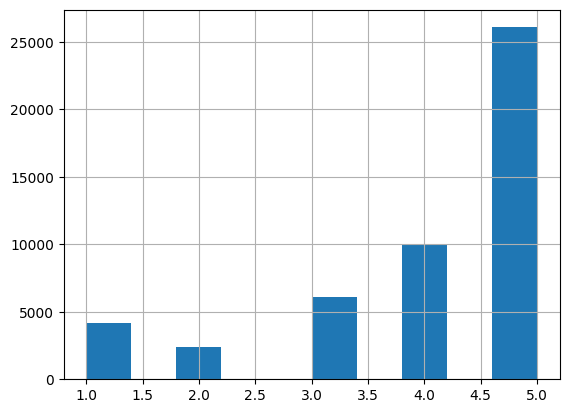

In [6]:
train_data['rate'].hist(); 

In [7]:
le = LabelEncoder()

train_data['rate'] = le.fit_transform(train_data['rate'])

# Оптимизация типов данных
train_data['rate'] = train_data['rate'].astype('uint8')

train_data.head()

,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    48665 non-null  uint8 
 1   text    48665 non-null  object
dtypes: object(1), uint8(1)
memory usage: 427.8+ KB


## Препроцессинг


word2vec:

65:
Download	100	10	Russian CoNLL17 corpus
3338424	Word2Vec Continuous Skipgram	False

204:
204	Download	300	2	Russian National Corpus
Russian Wikipedia dump of December 2018
Russian News from Dialogue Evaluation 2020
Araneum Russicum Maximum
998459	Gensim Continuous Bag-of-Words	True
True
True
True

In [9]:
import re
import nltk
import pymorphy2
from nltk.corpus import stopwords

# Путь к модели
path_to_model = DATA_PATH + '65/model.bin'

# Загрузка предварительно обученной модели (может потребовать много времени и памяти)
word_vectors = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

# Загрузка русских стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Удаление лишних символов и нормализация
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    
    # Токенизация
    words = nltk.word_tokenize(text, language="russian")
    
    # Удаление стоп-слов и лемматизация
    words = [morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords]
    
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Получение вектора для слова

In [10]:
word = 'компьютер'
if word in word_vectors:
    vector = word_vectors[word]
    print(f"Вектор для слова '{word}': {vector[:10]}")  # Печатаем первые 10 элементов для примера
else:
    print(f"Слово '{word}' не найдено в модели.")

Вектор для слова 'компьютер': [ 0.039719 -0.123894  0.340882 -0.101076  0.620852  0.315008  0.00749
  0.070636 -0.464991 -0.271156]


## Поиск похожих слов

In [11]:
# Поиск похожих слов
similar_words = word_vectors.most_similar(word)
print(f"Слова, похожие на слово '{word}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity}")


Слова, похожие на слово 'компьютер':
компьютера: 0.8421791195869446
комьютер: 0.8318662047386169
пк: 0.8002675175666809
компьютере: 0.8002145886421204
компьтер: 0.792725682258606
xexmenu: 0.7856771349906921
компъютер: 0.785533607006073
планшет: 0.7799608707427979
clear.fi: 0.7791236042976379
самвей: 0.7786980867385864


## Векторизация текста с использованием Word2Vec

In [12]:
def document_vector(word_vectors, doc):
    """Создание вектора для документа по среднему векторам слов."""
    words = doc.split()
    # Создание списка векторов для слов, найденных в модели
    vectors = [word_vectors[word] for word in words if word in word_vectors.key_to_index]
    
    # Если векторы найдены, возвращаем средний вектор, иначе вектор нулей
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)


## Предварительная обработка текста

In [13]:
train_data['clear_text'] = train_data['text'].apply([preprocess_text])

train_data = train_data.drop_duplicates(subset='clear_text', keep='last')

train_data['vector'] = train_data['clear_text'].apply(lambda doc: document_vector(word_vectors, doc))

In [14]:
train_vectors = np.array(list(train_data['vector'].values))
train_labels = train_data['rate'].values

In [15]:
test_data['clear_text'] = test_data['text'].apply([preprocess_text])
test_data['vector'] = test_data['clear_text'].apply(lambda doc: document_vector(word_vectors, doc))

In [16]:
test_vectors = np.array(list(test_data['vector'].values))

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_labels, test_size=0.025, random_state=42, shuffle=True)
# X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_labels, test_size=0.025, random_state=42, stratify=train_data['rate'], shuffle=True)

In [18]:
from catboost import Pool

# Создание пулов данных для CatBoost
train_pool = Pool(data=pd.DataFrame(X_train), label=y_train)
valid_pool = Pool(data=pd.DataFrame(X_test), label=y_test)


# Модель

In [33]:
from catboost import CatBoostClassifier
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(task_type='CPU',
								iterations = 500,
								eval_metric='TotalF1',
								od_type='Iter', 
								od_wait=500,
								depth=10,
								loss_function='MultiClass',
								random_seed=55,
								l2_leaf_reg=5.0,
								border_count=32,
								**kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=5, plot=True, 
                     use_best_model=True)

# Обучение

In [34]:
model = fit_model(train_pool, valid_pool, learning_rate=0.35,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                 feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4812586	test: 0.4294866	best: 0.4294866 (0)	total: 101ms	remaining: 50.2s
5:	learn: 0.5324745	test: 0.4724108	best: 0.4724108 (5)	total: 693ms	remaining: 57.1s
10:	learn: 0.5749176	test: 0.4941152	best: 0.4970488 (9)	total: 1.25s	remaining: 55.6s
15:	learn: 0.6047428	test: 0.5011725	best: 0.5088641 (14)	total: 1.82s	remaining: 55.2s
20:	learn: 0.6379705	test: 0.5162330	best: 0.5162330 (20)	total: 2.39s	remaining: 54.5s
25:	learn: 0.6663838	test: 0.5132876	best: 0.5239041 (24)	total: 2.97s	remaining: 54.2s
30:	learn: 0.6912425	test: 0.5190037	best: 0.5239041 (24)	total: 3.55s	remaining: 53.7s
35:	learn: 0.7138357	test: 0.5244871	best: 0.5246884 (31)	total: 4.18s	remaining: 53.9s
40:	learn: 0.7394192	test: 0.5299767	best: 0.5299767 (40)	total: 4.82s	remaining: 54s
45:	learn: 0.7625155	test: 0.5271740	best: 0.5299767 (40)	total: 5.47s	remaining: 54s
50:	learn: 0.7789702	test: 0.5251876	best: 0.5331190 (48)	total: 6.1s	remaining: 53.7s
55:	learn: 0.7975242	test: 0.5326111	best:

KeyboardInterrupt: 

# Предикт

# Формирование решения

In [21]:
y_pred = model.predict(test_vectors)
pred_labels = le.inverse_transform(y_pred)

print(pred_labels)

sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
sample_submission["rate"] = pred_labels
sample_submission.head()


[5 5 5 ... 5 5 2]


d:\Projects\NLP_course\.venv\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,index,rate
0,0,5
1,1,5
2,2,5
3,3,4
4,4,1


In [22]:
sample_submission.to_csv(DATA_PATH+"submission.csv", index=False)